<a href="https://colab.research.google.com/github/Yujini68/ESAA/blob/main/%EA%B3%BC%EC%A0%9C0429.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07 LightGBM

- XGBoost보다 학습에 걸리는 시간, 메모리 사용량이 훨씬 적으면서 예측 성능에는 차이가 없고 다양성이 더 많음

- 적은 데이터 세트에 적용할 경우 과적합이 발생하기 어려움

- 리프 중심 트리 분할 방식을 사용, 트리의 균형을 맞추지 않고 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리 생성 -> 예측 오류 손실 최소화

- 카테고리형 피처의 자동 변환과 최적 분할

- 대용량 데이터에 대한 뛰어난 예측 성능 및 병렬 컴퓨팅 기능 제공, GPU까지 지원



### LightGBM 설치

conda install -c conda-forge lightgbm

### LightGBM 하이퍼 파라미터

주요 파라미터

- num_iterations [default = 100] : 반복 수행하려는 트리의 개수 지정
- learning_rate[default = 0.1]: 0과 1 사이의 값 지정 -> 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값
- max_depth[default = 1]: 트리 기반 알고리즘의 max_depth와 동일
- max_data_in_leaf[default = 20]: 결정 트리의 min_samples_leaf와 같은 파라미터
= num_leaves[default = 31]: 하나의 트리가 가질 수 있는 최대 리프 개수
- boosting[default = gbdt]: 부스팅 트리 생성하는 알고리즘 기술
- bagging_fraction[default=1.0]: 트리가 커져서 과적합 되는 것을 제어하기 위해 데이터를 샘플링하는 비율 지정
- feature_fraction[default=1.0]: 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율
- lambda_l2[default=0.0]: L2 regulation 제어를 위한 값
- lambda_l1[default=0.0]: L1 regulation 제어를 위한 값

Learning Task 파라미터
- objective : 최솟값을 가져야할 손실 함수 정의, 애플리케이션의 유형(회귀, 다중클래스 분류, 이진분류)에 따라 손실함수 지정

### 하이퍼 파라미터 튜닝 방안

num_leaves 개수 중심으로 min_sample (min_data_in_leaf), max_depth 함께 조정하면서 모델의 복잡도 줄여나가는 것

### LightGBM 적용 - 위스콘신 유방암 예측

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
!pip install lightgbm==3.3.2
import lightgbm

In [23]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size = 0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400설정.
lgbm_wrapper=LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set = evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
def get_clf_eval(y_test, pred=None, pred_proba=None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # roc_auc 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [25]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도 : 0.9561, 정밀도 : 0.9500, 재현율 : 0.9870,     F1 : 0.9682, AUC:0.9905


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

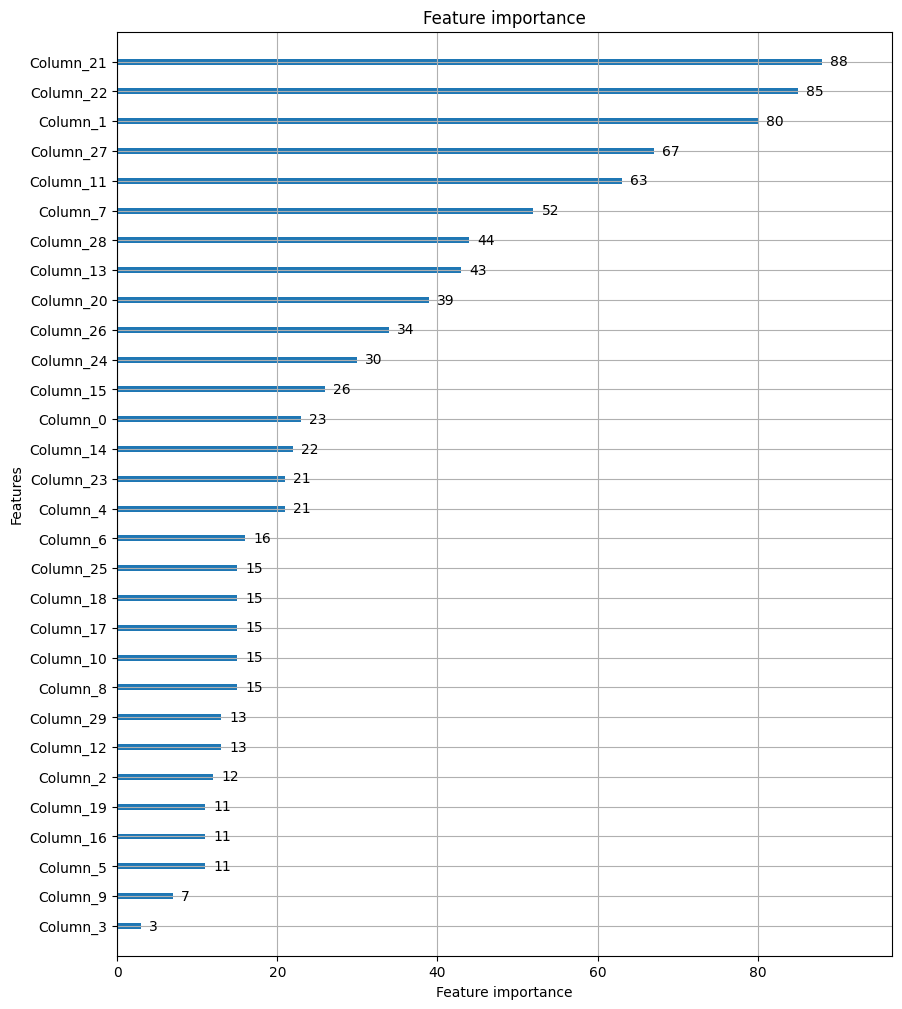

In [26]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

# 08 분류 실습 - 캐글 산탄테르 고객 만족 예측

### 데이터 전처리

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('/content/train.csv', encoding = 'latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [28]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [29]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [30]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [31]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
print('피처 데이터 shape: {0}'.format(X_features.shape))

피처 데이터 shape: (76020, 369)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size = 0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape: {0}, 테스트 세트 Shape: {1}'.format(X_train.shape, X_test.shape))

print('학습 세틑 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape: (60816, 369), 테스트 세트 Shape: (15204, 369)
학습 세틑 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

#n_estimator는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators=500, random_state = 156)

#성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83789	validation_1-auc:0.82554
[1]	validation_0-auc:0.84273	validation_1-auc:0.82878
[2]	validation_0-auc:0.84901	validation_1-auc:0.83359
[3]	validation_0-auc:0.85530	validation_1-auc:0.83767
[4]	validation_0-auc:0.85891	validation_1-auc:0.83909
[5]	validation_0-auc:0.86117	validation_1-auc:0.84156
[6]	validation_0-auc:0.86378	validation_1-auc:0.84138
[7]	validation_0-auc:0.86737	validation_1-auc:0.84048
[8]	validation_0-auc:0.87021	validation_1-auc:0.84162
[9]	validation_0-auc:0.87258	validation_1-auc:0.84100
[10]	validation_0-auc:0.87505	validation_1-auc:0.84117
[11]	validation_0-auc:0.87747	validation_1-auc:0.84111
[12]	validation_0-auc:0.87872	validation_1-auc:0.84114
[13]	validation_0-auc:0.88087	validation_1-auc:0.84066
[14]	validation_0-auc:0.88208	validation_1-auc:0.84014
[15]	validation_0-auc:0.88340	validation_1-auc:0.83965
[16]	validation_0-auc:0.88557	validation_1-auc:0.83950
[17]	validation_0-auc:0.88664	validation_1-auc:0.84013
[18]	validation_0-au

In [35]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params={ 'max_depth':[5,7], 'min_child_weight':[1,3],'colsample_bytree':[0.5,0.75] }
# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
           eval_set=[(X_train,y_train),(X_test,y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.80705	validation_1-auc:0.80366
[1]	validation_0-auc:0.80607	validation_1-auc:0.80683
[2]	validation_0-auc:0.79962	validation_1-auc:0.80156
[3]	validation_0-auc:0.80463	validation_1-auc:0.80839
[4]	validation_0-auc:0.82994	validation_1-auc:0.82595
[5]	validation_0-auc:0.84026	validation_1-auc:0.83143
[6]	validation_0-auc:0.84642	validation_1-auc:0.83616
[7]	validation_0-auc:0.84635	validation_1-auc:0.83399
[8]	validation_0-auc:0.85018	validation_1-auc:0.83592
[9]	validation_0-auc:0.85084	validation_1-auc:0.83463
[10]	validation_0-auc:0.85227	validation_1-auc:0.83362
[11]	validation_0-auc:0.85527	validation_1-auc:0.83695
[12]	validation_0-auc:0.85693	validation_1-auc:0.83944
[13]	validation_0-auc:0.85857	validation_1-auc:0.83941
[14]	validation_0-auc:0.85898	validation_1-auc:0.83988
[15]	validation_0-auc:0.85928	validation_1-auc:0.83954
[16]	validation_0-auc:0.86102	validation_1-auc:0.83887
[17]	validation_0-auc:0.86239	validation_1-auc:0.83818
[18]	validation_0-au

In [36]:
# n_estimators는 1000으로 증가시키고, lerning_rate=0.2로 감소, reg_alpha=0.03으로 추가함.
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.2, max_depth=5,
                        min_child_weight=3, colsample_bytree=0.5, reg_alpha=0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200,
            eval_metric='auc', eval_set = [(X_train, y_train),(X_test,y_test)])

xgb_roc_score=roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82460	validation_1-auc:0.81692
[1]	validation_0-auc:0.82522	validation_1-auc:0.81503
[2]	validation_0-auc:0.81902	validation_1-auc:0.81086
[3]	validation_0-auc:0.83489	validation_1-auc:0.82623
[4]	validation_0-auc:0.82946	validation_1-auc:0.82259
[5]	validation_0-auc:0.83879	validation_1-auc:0.83183
[6]	validation_0-auc:0.83597	validation_1-auc:0.83156
[7]	validation_0-auc:0.84208	validation_1-auc:0.83620
[8]	validation_0-auc:0.84341	validation_1-auc:0.83323
[9]	validation_0-auc:0.84275	validation_1-auc:0.83301
[10]	validation_0-auc:0.84935	validation_1-auc:0.83656
[11]	validation_0-auc:0.84961	validation_1-auc:0.83667
[12]	validation_0-auc:0.84899	validation_1-auc:0.83589
[13]	validation_0-auc:0.84885	validation_1-auc:0.83479
[14]	validation_0-auc:0.85341	validation_1-auc:0.83831
[15]	validation_0-auc:0.85367	validation_1-auc:0.83779
[16]	validation_0-auc:0.85376	validation_1-auc:0.83793
[17]	validation_0-auc:0.85769	validation_1-auc:0.83980
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

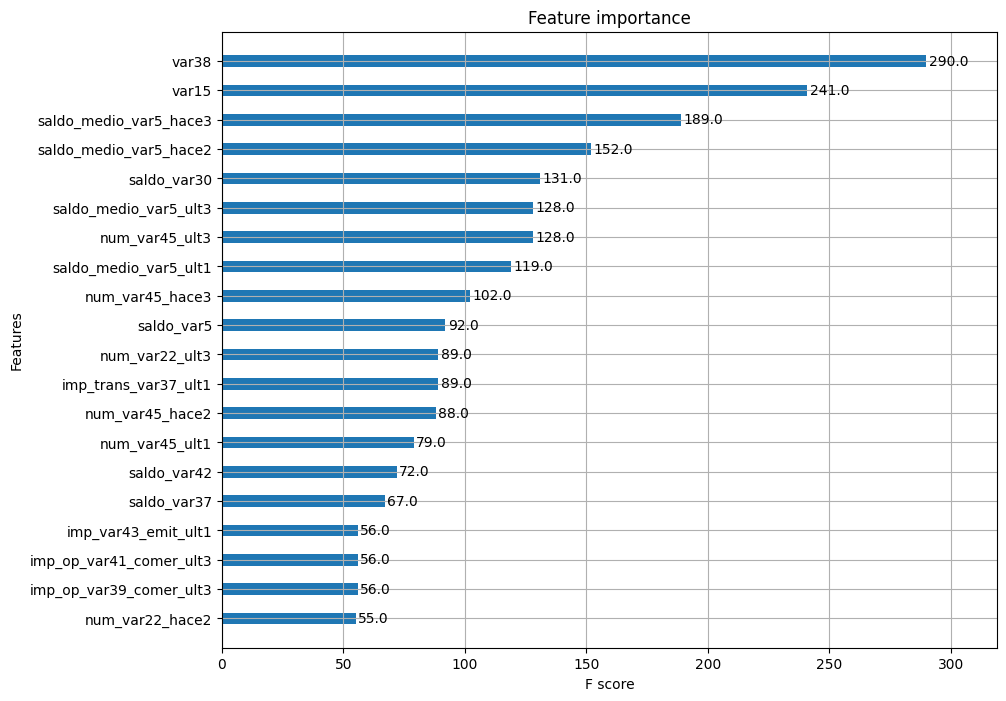

In [37]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline


fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [38]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 500)

evals = [(X_test,y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric='auc', eval_set = evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_logloss: 0.14161
[16]	valid_0's auc: 0.840337	valid_0's binary_loglo

In [39]:
lgbm_clf=LGBMClassifier(n_estimators=200)

params = {'num_leaves':[32,64],
          'max_depth':[128,160],
          'min_child_samples':[60,100],
         'subsample':[0.8,1]}

# cv는 3으로 지정
gridcv=GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
           eval_set=[(X_train, y_train),(X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.146543
[9]	valid_0's auc: 0.849328	v

In [40]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=100, max_depth=128)

evals=[(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals,
             verbose=True)

lgbm_roc_score=roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.141254
[16]	valid_0's auc: 0.841108	valid_0's binary_logloss: 0